# Introduction to Machine learning and Neural Ne
## Prepared by Karol Wesołowski, L2, 148116

## 1. Task

The task was to implement a simple decision tree generating algorith, including calculating gain and other values. The code was prepared in python using pandas. Graphs created using NetworkX. Report designed in Jupyter Notebook. Code uses several global structures to represent generated tree and to allow the tree to be properly shown in graphic form. `const_box` defines the size of nodes on the graph. `counter` is used to enumerate the nodes. Other structures are self-explanatory.

In [22]:
import math

import networkx as nx
from matplotlib import pyplot as plt
import pandas as pd

const_box = 4

## 2. Data

Data used in this task is a well known dataset called Titanic representing passengers of the ship and they're status after the catastrophy.

In [23]:
data = pd.read_csv("data/titanic-homework.csv", index_col="PassengerId")
print(data.head(10))

             Pclass                                               Name  \
PassengerId                                                              
1                 3                            Braund, Mr. Owen Harris   
2                 1  Cumings, Mrs. John Bradley (Florence Briggs Th...   
3                 3                             Heikkinen, Miss. Laina   
4                 1       Futrelle, Mrs. Jacques Heath (Lily May Peel)   
5                 3                           Allen, Mr. William Henry   
6                 3                                   Moran, Mr. James   
7                 1                            McCarthy, Mr. Timothy J   
8                 3                     Palsson, Master. Gosta Leonard   
9                 3  Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)   
10                2                Nasser, Mrs. Nicholas (Adele Achem)   

                Sex  Age  SibSp  Parch  Survived  
PassengerId                                       
1        

Data consist of several columns. `PassengerId` is treated as Dataframe identifier (index). `Name` is omitted in the calculations, since it does not provide any valuable data. `Pclass`, `Sex`, `SibSp` and `Parch` are discrete values and are used as attributes for decisions. `Age` is a continuous value and as such has to be mapped to discrete. `Survived` is the result of calculation.

In [24]:
def mapper(data: pd.DataFrame):
    data['Age'] = data.apply(lambda row: (
        "old" if row["Age"] > 40 else ("medium" if row["Age"] > 20 else "young")), axis=1)
    return data

Function `mapper` takes DataFrame as input and performs a mapping on column `Age` changing all values higher than 40 to label *old*, those between 40 (icl.) and 20 (excl.) - to *medium* and lower or equal to 20 to *young*. 
Every preparation is done in the function `prepare_data`. Additionally, the functions extracts the outcome column and saves it as np.Series:

In [25]:
def prepare_data():
    data = pd.read_csv("data/titanic-homework.csv", index_col="PassengerId")
    outcome = data['Survived']
    outcome.name = "outcome"
    data = data.drop(['Name', 'Survived'], axis='columns')
    data = mapper(data)
    return data, outcome

Prepared data looks as follows:

In [26]:
data, outcome = prepare_data()
print("data")
print(data.head())
print("outcome")
print(outcome.head())

data
             Pclass     Sex     Age  SibSp  Parch
PassengerId                                      
1                 3    male  medium      1      0
2                 1  female  medium      1      0
3                 3  female  medium      0      0
4                 1  female  medium      1      0
5                 3    male  medium      0      0
outcome
PassengerId
1    0
2    1
3    1
4    1
5    0
Name: outcome, dtype: int64


## 3. Statistics

To build a decision tree it is necessary to choose the best branch. It can be done using a value called entropy. This value defines how much various information is in one message (block of data). If entropy is equal to 0, it means that the block is pure and contains only one type of data. Entropy on one column is defined as follows:

In [27]:
def single_entropy(value: int, size: int):
    if value == 0:
        return 0
    return -1 * (value / size) * math.log2((value / size))

`entropy` function uses the above function to calculate the entropy on the given column. It performs necessary preparations (concatenating tables, selecting only the interesting columns, grouping them by value) and returns entropy of the attribute as well as cleaned data. The results can be seen below.

In [28]:
def entropy(data: pd.DataFrame, outcome: pd.Series, column: str):
    used_data = data[column]
    used_data.name = column
    size = used_data.size
    used_data = pd.concat([used_data, outcome], axis=1)
    positives = used_data.groupby(column)['outcome'].sum()
    counts = used_data.groupby(column)['outcome'].count()
    used_data = pd.concat([positives, counts], axis=1)
    used_data.columns = ['positives', 'count']
    used_data['entropy'] = used_data.apply(lambda row: single_entropy(row['positives'], size), axis=1)
    return used_data['entropy'].sum(), used_data


for col in data.columns:
    ent, aggr = entropy(data, outcome, col)
    print(f"Entropy: {col}: {ent}")

Entropy: Pclass: 1.1571514757368124
Entropy: Sex: 0.7963775719775679
Entropy: Age: 1.1208917147235118
Entropy: SibSp: 1.04638292837967
Entropy: Parch: 1.0136302372796246


Entropy output on the first level: 
Entropy: Pclass: 1.1571514757368124
Entropy: Sex: 0.7963775719775679
Entropy: Age: 1.1208917147235118
Entropy: SibSp: 1.04638292837967
Entropy: Parch: 1.0136302372796246


Based on the calculated values, the program has to perform next operations to get information gain. For that it uses so-called **conditional entropy** (entropy multiplied by the probability of occurrence of value in the dataset). The gain is calculated as the difference between entropy on a branch and conditional entropy on that branch.

In [29]:
def conditional_entropy(data: pd.DataFrame):
    data["cond_ent"] = data.apply(lambda row: row["positives"] / row['count'] * row['entropy'], axis=1)
    return data['cond_ent'].sum(), data

for col in data.columns:
    ent, aggr = entropy(data, outcome, col)
    cond, aggr = conditional_entropy(aggr)
    gain = ent - cond
    print(f"Gain: {col}: {gain}")

Gain: Pclass: 0.6027622921172374
Gain: Sex: 0.32959259628704823
Gain: Age: 0.6666789398367434
Gain: SibSp: 0.6116056296194047
Gain: Parch: 0.5699623118738932


In general, gain is sufficient for constructing trees. But in some dataset it may be needed to calculate also ** intrinsic gain **. That value is the used to divide the gain and normalises it.

In [30]:
def intrinsic(data: pd.DataFrame):
    data['intr'] = data.apply(lambda row: single_entropy(row['positives'], row['count']), axis=1)
    return data['intr'].sum(), data

for col in data.columns:
    ent, aggr = entropy(data, outcome, col)
    cond, aggr = conditional_entropy(aggr)
    gain = ent - cond
    intr, aggr = intrinsic(aggr)
    if intr != 0:
        ratio = gain / intr
    else:
        ratio = 0
    print(f"Ratio: {col}: {ratio}")

Ratio: Pclass: 0.43409021347716104
Ratio: Sex: 0.5580847615421273
Ratio: Age: 0.42572837608378944
Ratio: SibSp: 0.2910303997343847
Ratio: Parch: 0.281110416720371


Gain ration on the first level:
Ratio: Pclass: 0.43409021347716104
Ratio: Sex: 0.5580847615421273
Ratio: Age: 0.42572837608378944
Ratio: SibSp: 0.2910303997343847
Ratio: Parch: 0.281110416720371


This set of instructions is used to choose the attribute, that will create the purest data after the division. This choice is performed using `best_branch` function.

In [31]:
def best_branch(data, outcome):
    results = {}
    for col in data.columns:
        ent, aggr = entropy(data, outcome, col)
        cond, aggr = conditional_entropy(aggr)
        gain = ent - cond
        intr, aggr = intrinsic(aggr)
        if intr != 0:
            ratio = gain / intr
        else:
            ratio = 0
        results[col] = ratio
    results = pd.DataFrame.from_dict(results, orient="index")
    results.columns = ["ratio"]
    results = results.sort_values("ratio", ascending=False)
    cond = True
    i = 1
    while cond:
        best_col = results.head(i).tail(1).index.values[0]
        gb = len(data.groupby(best_col)[best_col].count())
        cond = gb < 2
        i += 1
    return best_col

print(f"Best branch in current state: {best_branch(data, outcome)}")

Best branch in current state: Sex


## 4. Tree

The tree is generated recursively repeating the best branch choice and dividing data based on that choice. The calculation is finished, when the achieved data is pure, i.e. contains only outcome belonging to one category. To check for purity program uses the so called function. This function takes the selected column, split data based on the values in this attribute and counts if the category in outcome applies for every row. 

In [32]:
def purity_check(data, outcome, col):
    used_data = data[col]
    used_data.name = col
    used_data = pd.concat([used_data, outcome], axis=1)
    positives = used_data.groupby(col)['outcome'].sum()
    counts = used_data.groupby(col)['outcome'].count()
    used_data = pd.concat([positives, counts], axis=1)
    used_data.columns = ['positives', 'count']
    used_data['pure'] = used_data.apply(lambda row: row['positives'] == row['count'] or row['positives'] == 0, axis=1)
    purity = used_data['pure'].sum() == used_data.shape[0]
    return purity, used_data

best = best_branch(data, outcome)
purity, res = purity_check(data, outcome, best)
print(f"purity: {purity}")
print(res)

purity: False
        positives  count   pure
Sex                            
female         33     40  False
male            7     60  False


The function `build_tree` is recursive and takes three arguments:
1. data
2. outcome
3. depth - current level of the tree, used to present the result.
In each iteration the function finds the best branch and calculates the purity on it. Then, for every category in the selected attribute, it checks, if it contains pure data. If so, decision is printed and the execution returns. Otherwise, the data is prepared for the new iteration. Selected are only rows with fitting category, currently processed column is dropped. The execution is resumed on the new level.
4. Result is presented in the text form, with indentation indicating the level of the tree

In [33]:
def build_tree(data, outcome, depth=0):
    best = best_branch(data, outcome)
    purity, res = purity_check(data, outcome, best)
    
    for row in res.iterrows():
        print(depth * '\t' + best + ' - ' + str(row[0]) + ': ')
        if not row[1]['pure']:
            new_data = data[data[best] == row[0]]
            new_data = new_data.drop(best, axis='columns')
            new_out = outcome[new_data.index]
            build_tree(new_data, new_out, depth + 1)
        else:
            print((depth + 1) * '\t' + f"decision:{1 if row[1]['positives'] > 0 else 0}")
    return

build_tree(data, outcome)

Sex - female: 
	Pclass - 1: 
		decision:1
	Pclass - 2: 
		decision:1
	Pclass - 3: 
		Age - medium: 
			SibSp - 0: 
				decision:1
			SibSp - 1: 
				Parch - 0: 
					decision:0
				Parch - 5: 
					decision:1
			SibSp - 3: 
				decision:1
		Age - old: 
			decision:1
		Age - young: 
			SibSp - 0: 
				decision:1
			SibSp - 1: 
				Parch - 0: 
					decision:0
				Parch - 1: 
					decision:1
			SibSp - 2: 
				decision:0
			SibSp - 3: 
				decision:0
			SibSp - 4: 
				decision:1
			SibSp - 5: 
				decision:0
Sex - male: 
	SibSp - 0: 
		Age - medium: 
			Parch - 0: 
				Pclass - 1: 
					decision:1
				Pclass - 2: 
					decision:0
				Pclass - 3: 
					decision:0
			Parch - 1: 
				decision:1
		Age - old: 
			decision:0
		Age - young: 
			Parch - 0: 
				Pclass - 1: 
					decision:1
				Pclass - 2: 
					decision:1
				Pclass - 3: 
					decision:0
			Parch - 2: 
				decision:1
	SibSp - 1: 
		Pclass - 1: 
			decision:0
		Pclass - 2: 
			decision:0
		Pclass - 3: 
			Age - medium: 
				Parch

## 5. Visualisation

Packet NetworkX is used to convert text output into graphical one. The main visualisation function looks as follows:

In [34]:
def calculate_pos():
    pos = {}
    max_x = 2 * const_box * (len(flat) + 1)
    for i, row in enumerate(flat):
        if len(row) > 0:
            y = const_box * (len(flat) + 1 - i)
            step = max_x / len(row)
            x = step / 2
            for node in row:
                pos[node] = (x, y)
                x += step
    return pos

def visualise(title: str = "graph"):
    plt.figure(figsize=(2*(len(flat)), 2*(len(flat))))
    G = nx.DiGraph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)
    pos = calculate_pos()
    nx.draw_networkx(G, pos=pos, labels=labels, arrows=True,
                     bbox=dict(facecolor="skyblue",
                               boxstyle="round", pad=0.3),
                     edge_color="gray")
    nx.draw_networkx_edge_labels(G, pos=pos,
                                 edge_labels=edges_l,
                                 font_color='black')
    plt.title(title)
    plt.savefig(title + '.png', dpi=300)
    plt.show()
    

`calculate_pos` is used to determine positions of nodes on the printout. To visualise the tree, function need following structures:
- list of all nodes (as numbers)
- list of all edges (as a pair of number from above list)
- list of positions (pair of numbers, calculated above)
- dictionary of node labels (int:str)
- dictionary of edge labels (pair(int, int):str)
Flat is an additional structure, representing the tree as a list of lists of nodes used to calculate positions. 
To obtain all the information, the `build_tree` function has to be modified in the following way:


In [35]:
def build_tree(data, outcome, depth=0, parent=-1, desc=""):
    global nodes, flat, edges, counter, labels
    while len(flat) <= depth + 1:
        flat.append([])
        
    best = best_branch(data, outcome)
    purity, res = purity_check(data, outcome, best)
    nodes.append(counter)
    flat[depth].append(counter)
    labels[counter] = best
    if parent != -1:
        edges.append((parent, counter))
        edges_l[(parent, counter)] = desc
    current = counter
    counter += 1

    for row in res.iterrows():
        desc = str(row[0])
        if not row[1]['pure']:
            new_data = data[data[best] == row[0]]
            new_data = new_data.drop(best, axis='columns')
            new_out = outcome[new_data.index]
            build_tree(new_data, new_out, depth + 1, current, desc)
        else:
            decision = 1 if row[1]['positives'] > 0 else 0
            nodes.append(counter)
            labels[counter] = decision
            edges.append((current, counter))
            edges_l[(current, counter)] = desc
            flat[depth + 1].append(counter)
            counter += 1
    return

That concludes the execution. The functions have to be called in following order. The graph is saved to .png file with the same name as the title of the graph, provided as the argument ('graph.png' by default)

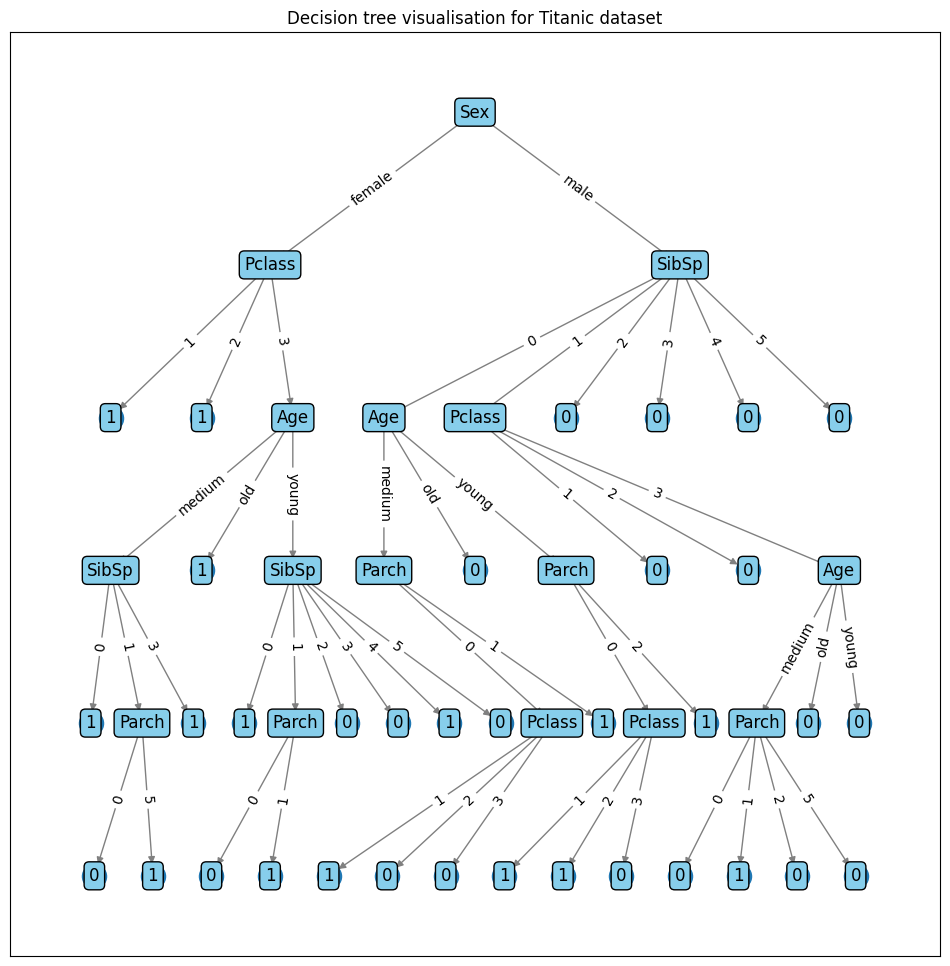

In [36]:
flat = []
edges = []
nodes = []
labels = {}
edges_l = {}
counter = 0

data, outcome = prepare_data()
build_tree(data, outcome)
visualise("Decision tree visualisation for Titanic dataset")

![Visualisation](Decision%20tree%20visualisation%20for%20Titanic%20dataset.png)

## 6. Continuous Mapping
As an additional feature, the tree may take the incoming continuous values, and not map them statically, but rather dynamically. This requires the introduction of the following function, called `cont_mapping`. This function takes three positional arguments, data set, series with results of classification and name of the column, on which to do the mapping, and additionally, has a keyword argument, defining the smallest allowed group, by default set to two. This action can (and will) lead to some uncertainty in the results, as not all splits will generate pure subsets. To accommodate this, mode (dominant) is introduced and used to calculate the value for unclassified arguments.

In [37]:
def cont_mapper(data: pd.DataFrame, out: pd.Series, col: str, min_group: int = 2):
    results = {}
    u_data = data[col]
    s = u_data.size
    data.name = col
    u_data = pd.concat([u_data, out], axis=1)
    u_data = u_data.sort_values(col)

    last = u_data["outcome"].iloc[0]
    for i in range(min_group, s - min_group):
        if u_data["outcome"].iloc[i] != last:
            last = u_data["outcome"].iloc[i]
            upper = u_data.head(i + 1)
            upper_stat = (upper["outcome"].sum()) / (i + 1)
            lower = u_data.tail(s - 1 - i)
            lower_stat = (lower["outcome"].sum()) / (s - 1 - i)
            entry = [upper_stat, 1 - upper_stat, lower_stat, 1 - lower_stat]
            results[i] = entry
    ans = pd.DataFrame.from_dict(results, "index")
    ans.columns = ["up", "neg_up", "low", "neg_low"]
    maks = (ans.max().idxmax(), ans[ans.max().idxmax()].idxmax())
    cut_age = u_data["Age"].iloc[maks[1]] - 0.5
    data['Age'] = data.apply(lambda row: (
        "younger" if row["Age"] < cut_age else "older"), axis=1)
    return data
    

In [38]:
data = pd.read_csv("data/titanic-homework.csv", index_col="PassengerId")
outcome = data['Survived']
outcome.name = "outcome"
data = data.drop(['Name', 'Survived'], axis='columns')
data = cont_mapper(data, outcome, "Age")

In addition to this new function, some minor changes have to be made. 

For one, `prepare data` function has to have the possibility to skip the mapping. 

`best_branch` functions gets new argument `cont_col`, indicating the list of columns to be mapped continuously. This is taken into account and mapped accordingly. This function also has now the possibility to return "unclassified" value, when the splits omit all the columns in the table. 

`build_tree` function also has the new argument, `cont_col`, which is passed to `best_branch`. Besides that, it reacts to the unclassified values, by calculating the mode of the uncertain outcome. 



In [39]:
def prepare_data(skip_mapping=False):
    data = pd.read_csv("data/titanic-homework.csv", index_col="PassengerId")
    outcome = data['Survived']
    outcome.name = "outcome"
    data = data.drop(['Name', 'Survived'], axis='columns')
    # new part
    if not skip_mapping:
        data = mapper(data)
    # ---
    return data, outcome

In [40]:
def best_branch(data, outcome, cont_col=[]):
    results = {}
    # new part
    if len(cont_col) > 0:
        for col in cont_col:
            data = cont_mapper(data, outcome, col)
    # ---
    for col in data.columns:
        ent, aggr = entropy(data, outcome, col)
        cond, aggr = conditional_entropy(aggr)
        gain = ent - cond
        intr, aggr = intrinsic(aggr)
        if intr != 0:
            ratio = gain / intr
        else:
            ratio = 0
        results[col] = ratio
    # changes
    if len(results) > 0:
        results = pd.DataFrame.from_dict(results, orient="index")
        results.columns = ["ratio"]
        results = results.sort_values("ratio", ascending=False)
        cond = True
        i = 1
        while cond:
            best_col = results.head(i).tail(1).index.values[0]
            gb = len(data.groupby(best_col)[best_col].count())
            cond = gb < 2
            i += 1
        return best_col
    else:
        return "unclassified"
    # ---

In [41]:
def build_tree(data, outcome, depth=0, parent=-1, desc="", cont_col=[]):
    global nodes, flat, edges, counter, labels
    while len(flat) <= depth + 1:
        flat.append([])
    best = best_branch(data, outcome, cont_col)
    # new part
    if best == "unclassified":
        nodes.append(counter)
        flat[depth].append(counter)
        test = outcome.sum()
        if test == 0 or test == outcome.size:
            decision = outcome.mode().values[0]
        else:
            decision = "~" + str(outcome.mode().values[0])
        labels[counter] = decision
        edges.append((parent, counter))
        edges_l[(parent, counter)] = desc
        print((depth + 1) * '\t' + f"decision:{decision}")
        counter += 1
        return
    # ---

    purity, res = purity_check(data, outcome, best)
    nodes.append(counter)
    flat[depth].append(counter)
    labels[counter] = best
    if parent != -1:
        edges.append((parent, counter))
        edges_l[(parent, counter)] = desc
    current = counter
    counter += 1

    for row in res.iterrows():
        desc = str(row[0])
        print(depth * '\t' + best + ' - ' + desc + ': ')
        if not row[1]['pure']:
            new_data = data[data[best] == row[0]]
            new_data = new_data.drop(best, axis='columns')
            new_out = outcome[new_data.index]
            build_tree(new_data, new_out, depth + 1, current, desc)

        else:
            decision = 1 if row[1]['positives'] > 0 else 0
            print((depth + 1) * '\t' + f"decision:{decision}")
            nodes.append(counter)
            labels[counter] = decision
            edges.append((current, counter))
            edges_l[(current, counter)] = desc
            flat[depth + 1].append(counter)
            counter += 1
    return

All statistical and visualization methods are left unchanged. The result is obtained the same way. Due to using the same canvas, the difference in the trees can be seen.

Sex - female: 
	Pclass - 1: 
		decision:1
	Pclass - 2: 
		decision:1
	Pclass - 3: 
		SibSp - 0: 
			decision:1
		SibSp - 1: 
			Parch - 0: 
				decision:0
			Parch - 1: 
				decision:1
			Parch - 5: 
				decision:1
		SibSp - 2: 
			decision:0
		SibSp - 3: 
			Parch - 0: 
				decision:1
			Parch - 1: 
				decision:0
		SibSp - 4: 
			decision:1
		SibSp - 5: 
			decision:0
Sex - male: 
	Age - older: 
		decision:0
	Age - younger: 
		SibSp - 0: 
			Parch - 0: 
				Pclass - 1: 
						decision:~1
				Pclass - 2: 
						decision:~0
				Pclass - 3: 
					decision:0
			Parch - 1: 
				decision:1
			Parch - 2: 
				decision:1
		SibSp - 1: 
			Pclass - 1: 
				decision:0
			Pclass - 2: 
				decision:0
			Pclass - 3: 
				Parch - 0: 
					decision:0
				Parch - 1: 
					decision:1
				Parch - 2: 
					decision:0
				Parch - 3: 
					decision:0
				Parch - 5: 
					decision:0
		SibSp - 2: 
			decision:0
		SibSp - 3: 
			decision:0
		SibSp - 4: 
			decision:0
		SibSp - 5: 
			decision:0


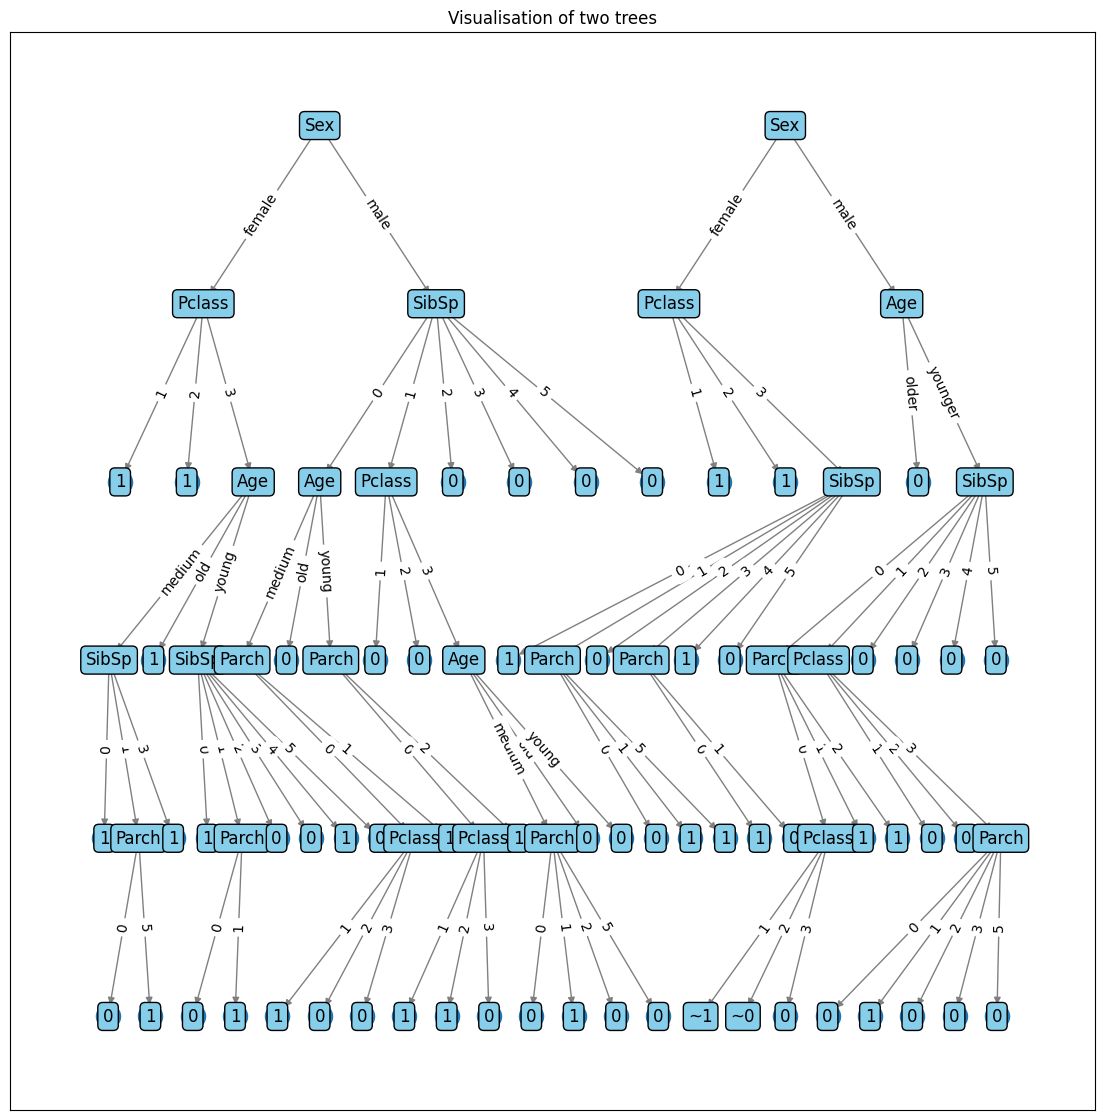

In [42]:
data, outcome = prepare_data(skip_mapping=True)
build_tree(data, outcome, cont_col=["Age"])
visualise("Visualisation of two trees")

![](Visualisation%20of%20two%20trees.png)

## 7. Summary

Continuous mapping gives the program more flexibility, but at the same time, limits its accuracy. Some values may become uncertain. But with the clear results it is easy to track down the classification for the newcomming data.